In [1]:
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt 
from ipywidgets import interact, FloatSlider, IntSlider, fixed, interactive
from filterpy.kalman import predict, update
from filterpy.stats import plot_covariance
from scipy.linalg import inv
import pandas as pd
%run utils.py

# KALMAN FILTER

1. Introdução à Assimilação de Dados
- Revisão de Estatística e Variáveis Normais
- Kalman Filter Unidimensional
- Revisão sobre Variáveis Normais Multivariadas
- Kalman Filter Multivariado

## Assimilação de dados

**Idéia principal**

Combinar Conhecimento teórico sobre um sistema com dados observados

## Medição de Dados

- Dados coletados do ambiente real
 - Podem não ser precisos o suficiente

## Exemplo - GPS estacionário

- Realiza medições para calcular a localização do GPS
- As medições realizadas não são exatas. Possuem uma variância

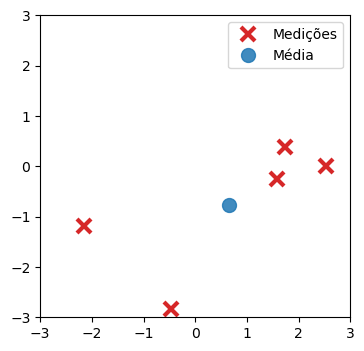

In [2]:
observations = np.random.normal(0, 1, size = (50, 2))
interact(lambda n_obs: gps_stationary_example(n_obs, observations),
         n_obs = IntSlider(value = 1, min = 1, max = 50));

### Modelo Matemático

Representa conhecimento teórico sobre o sistema


- Modelos de sistemas dinâmicos
 - O estado do sistema é representado por variáveis de estado
 - O estado do sistema evoluí por meio de uma dinâmica descrita por equações diferenciais (sistemas contínuos) ou de diferença (sistemas discretos)
 - O estado atual depende do estado anterior
- Viés de projeções - Modelos não são perfeitos!
 - Apenas aproximam processos complexos
 - Valores de parâmetros raramente (ou nunca) são totalmente corretos

## Exemplo - GPS de um veículo

- Sabemos a região em que o carro estava há um momento atrás

- Sabemos o modelo que descreve o comportamento do carro
 - $S = S_0 + v \cdot \Delta t$
- Então, se soubermos a velocidade do carro, podemos prever sua proxima posição aproximada

**Então temos duas fontes fontes de informação!**

- Posição estimada pelo GPS
- Posição prevista pelo modelo

O trabalho do algoritmo de assimilação de dados é unir as duas informações para melhorar a estimativa da posição do carro

## Distinto de machine learning

- Aprendizado de Máquinas
 - Não possuímos nenhum conhecimento prévio do sistema.
 - Aprende apenas pelos dados.
 - Modelos mais flexíveis, portanto mais difíceis de calibrar.
 - Ajuste de parâmetros é geralmente offline (não sempre) durante etapa de treinamento.
- Assimilação de dados
 - Já conhecemos o comportamento do sistema.
 - Modelos menos flexíveis, portanto mais fáceis de calibrar.
 - Ajusta parâmetros em tempo de execução.

# Revisão de Estatística e Variáveis Normais


## **Função Gaussiana**

- Funções Gaussianas são muito utilizadas para representar incertezas no mundo real.

- No Kalman Filter queremos descrever variáveis como funções gaussianas.

<img src="./fig/gausscurve.png" style="width: 400px;">


### **Função de Distribuição Normal (Gaussiana)**

- Função de distribuição de probabilidade contínua que pode ser descrita através de dois parâmetros,uma média ($\mu$) e uma variância ($\sigma^2$). 

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

Quem são os valores que descrevem uma Gaussiana?

### - Média

A média associada a uma função probabilidade é a tendência de resultados de um evento a permanecerem ao redor de um determinado ponto (ponto médio). Podemos considerar a média como uma estimativa de um evento.


### - Variância

A variância associada a uma função de probabilidade mede a dispersão dos resultados de um evento ao redor da média. Quanto maior a variância, menos conhecemos do evento que estudamos e menos precisa é a previsão feita.

Notação para função Gaussiana: ${\displaystyle X\sim {N}(\mu ,\sigma ^{2}).}$ 

- Na função Gaussiana, a probabilidade do evento obter um resultado próximo da média é muito maior do que um resultado longe da média.

<center><img src="./fig/probgaussiana.png" style="width: 50%;"></center>

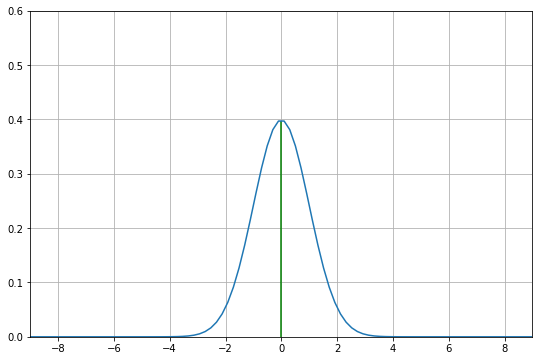

In [3]:
interact(plot_gaussian,
         x_mean = FloatSlider(value = 0, min = -8, max = 8),
         x_var = FloatSlider(value = 0.6, min = 0, max = 5));

## **Operações associadas a Gaussianas:**

Para o Filtro de Kalman, vamos utilizar conceitos de operações entre funções Gaussianas de variáveis aleatórias **independentes**.


### - Soma 

Dado dois eventos independentes ${\displaystyle X\sim {N}(\mu
_1 ,\sigma_1 ^{2})}$ e ${\displaystyle Y\sim {N}(\mu_2 ,\sigma_2 ^{2})}$. 

Sua soma resulta em um evento com os parâmetros:

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

Essa operação pode ser demonstrada por meio da operação de convolução entre duas distribuições normais.

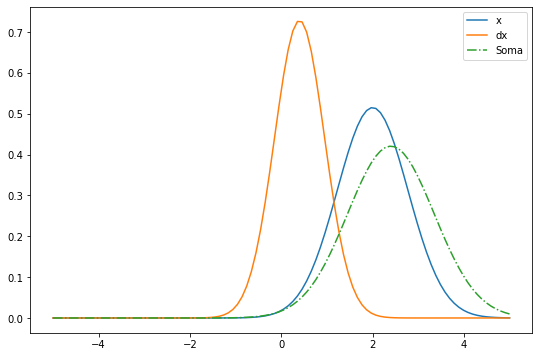

In [4]:
interact(plot_gaussian_sum,
         x_mean = FloatSlider(value = 0, min = 0, max = 5),
         x_var = FloatSlider(value = 0.6, min = .1, max = 3),
         dx_mean = FloatSlider(value = .4, min = -1, max = 1),
         dx_var = FloatSlider(value = 0.3, min = .1, max = 3));

### - Produto

Dado dois eventos independentes: ${\displaystyle X\sim {N}(\mu_1 ,\sigma_1 ^{2})}$ e ${\displaystyle Y\sim {N}(\mu_2 ,\sigma_2 ^{2})}$. 

O produto  resulta em uma função gaussiana de parâmetros:
 
$$
\mu =\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}
$$

$$
\sigma^2 =\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
$$

Essa operação pode ser demonstrada utilizando o teorema de Bayes.




- A gaussiana resultante da multiplicação de duas gaussianas independentes sempre terá variância menor do que as variâncias das gaussianas originais. 



- Então, com essa operação diminuímos a incerteza em relação a um novo evento. 


- Para Análise de dados: quanto mais informações temos sobre um determinado processo, menor a incerteza de seu resultado. 



- O Filtro de Kalman utiliza as propriedades de operações entre gaussianas para minimizar a variância de suas estimativas.


var_estimado =  0.388235294117647


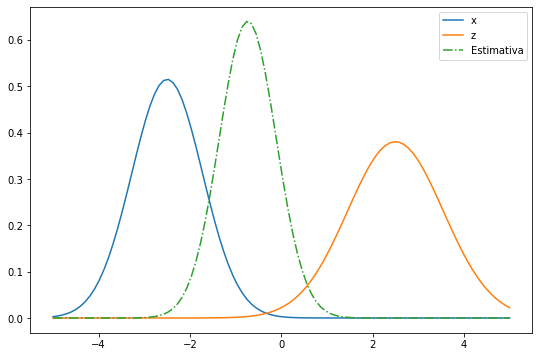

In [5]:
interact(plot_gaussian_multiplication,
         x_mean = FloatSlider(value = -2.5, min = -3, max = 3),
         x_var = FloatSlider(value = 0.6, min = 0, max = 3),
         z_mean = FloatSlider(value = 2.5, min = 0, max = 3),
         z_var = FloatSlider(value = 1.1, min = 0, max = 3));

# Filtro de Kalman Unidimensional 

<center><img src="./fig/esquema_kf_1.jpg" style="width: 60%"></center>

## Passos Filtro de Kalman 

<center><img src="./fig/data_assimilation.png" style = "width: 50%"></center>

## Passos do filtro de Kalman

<center><img src="./fig/gh_estimate3.png" style="width: 70%"></center>

## Predict

- Utiliza modelo matemático para prever o estado proximo passo de tempo
 - O resultado da predição é chamado de ***prior***

## Predict

- Cálculo da média do *prior*

$$\mu = \mu_1 + \mu_2 \quad \to \quad \bar x = x + dx$$

- Cálculo da variância do *prior*

$$\sigma^2 = \sigma^2_1 + \sigma^2_2 \quad \to \quad \bar \sigma_x^2 = \sigma_x^2 + \sigma_{dx}^2$$

Onde:

- $x$ é a média do *posterior* no passo de tempo anterior;
- $\sigma_x^2$ é a variância do *posterior* no passo de tempo anterior;
- $dx$ é o resultado do cálculo da derivada realizado pelo modelo;
- $\sigma_{dx}^2$ é a variância do modelo (e.g. a incerteza da predição).

## Update - Média

- Podemos derivar a fórmula da média pela operação de produto entre duas gaussianas independentes:

$$\mu=\frac{\bar\sigma_x^2\, \mu_z + \sigma_z^2 \, \bar x} {\bar\sigma_x^2 + \sigma_z^2} \quad \to \quad \mu = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma_x^2 + \sigma_z^2}\right)\bar x$$

Onde:
- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor

## Update - Média

- Podemos derivar a fórmula da média pela operação de produto entre duas gaussianas independentes:

$$\mu = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma_x^2 + \sigma_z^2}\right)\bar x$$

$$\mu = W_1 \mu_z + W_2 \bar x \quad \to \quad W_2 = (1 - W_1)$$

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar x\\
&= \bar x + K(\mu_z - \bar x)
\end{aligned}$$

- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor
- $K = W_1$ é a proporção chamada de ***Kalman gain***

## Update - Variância
- Também podemos expressar a variância em termos do *Kalman gain*

$$K = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right)$$

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma_x^2 \sigma_z^2 } {\bar\sigma_x^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma_x^2 
\end{aligned}$$

## Filtro de Kalman

**Predict**

$$\bar x = x + dx$$
$$\sigma_x^2 = \sigma_x^2 + \sigma_{dx}^2$$

**Update**

$$K = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right)$$
$$\mu = \bar x + K(\mu_z - \bar x)$$
$$\sigma_x^2 = (1-K)\bar\sigma_x^2$$

- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor
- K é a proporção chamada de ***Kalman gain***

In [6]:
def predict(posterior, modelo):
    x, P = posterior # Media e variancia do posterior no passo anterior
    dx, Q = modelo # Media e variancia do modelo
    x = x + dx
    P = P + Q
    return gaussian(x, P)

In [7]:
def update(prior, measurement):
    x, P = prior        # Media e variancia do prior
    z, R = measurement  # Media e variancia do sensor
    
    y = z - x        # Residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # Media do novo posterior
    P = (1 - K) * P  # Variancia do novo posterior
    return gaussian(x, P)

In [8]:
def movimento(t, posicao, velocidade):
    return velocidade

In [9]:
# Inicializacao do Modelo
posicao = 0
velocidade = 5 # Velocidade constante
tf = 10
dt = 0.5
Q = 1 # Variancia do modelo
R = 5 # Variancia do sensor

pos_real = [posicao]
zs = [posicao + np.random.normal(0, R)]

for t in np.arange(0, tf, dt):
    # Incrementa posicao
    posicao = posicao + movimento(t, posicao, velocidade) * dt + np.random.normal(0, Q)
    pos_real.append(posicao)
    
    # Acrescenta ruido do sensor
    zs.append(posicao + np.random.normal(0, R))

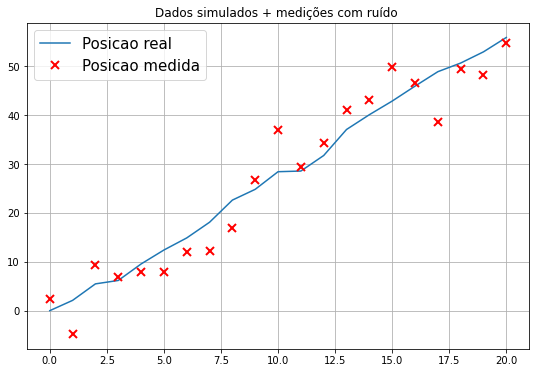

In [10]:
plt.figure(figsize = (9, 6))
plt.plot(pos_real)
plt.plot(zs, 'xr', mew = 2, ms = 8)
plt.grid()
plt.title("Dados simulados + medições com ruído ")
plt.legend(["Posicao real", "Posicao medida"], prop={'size': 15});

In [11]:
zs[6]

12.042380258764304

In [12]:
# Inicializacao
# Para ilustrar o funcionamento do filtro,
# a posição inicial (posterior[0]) recebe zs[0] + 50
posterior = gaussian(zs[0]+50, R)
predito = []
estimado = []
modelo = []
for z in zs:
    dx = movimento(t, posterior.mean, velocidade) * dt
    
    prior = predict(posterior, gaussian(dx, Q))
    posterior = update(prior, gaussian(z, R))
    
    modelo.append(gaussian(dx, Q))
    predito.append(prior)
    estimado.append(posterior)

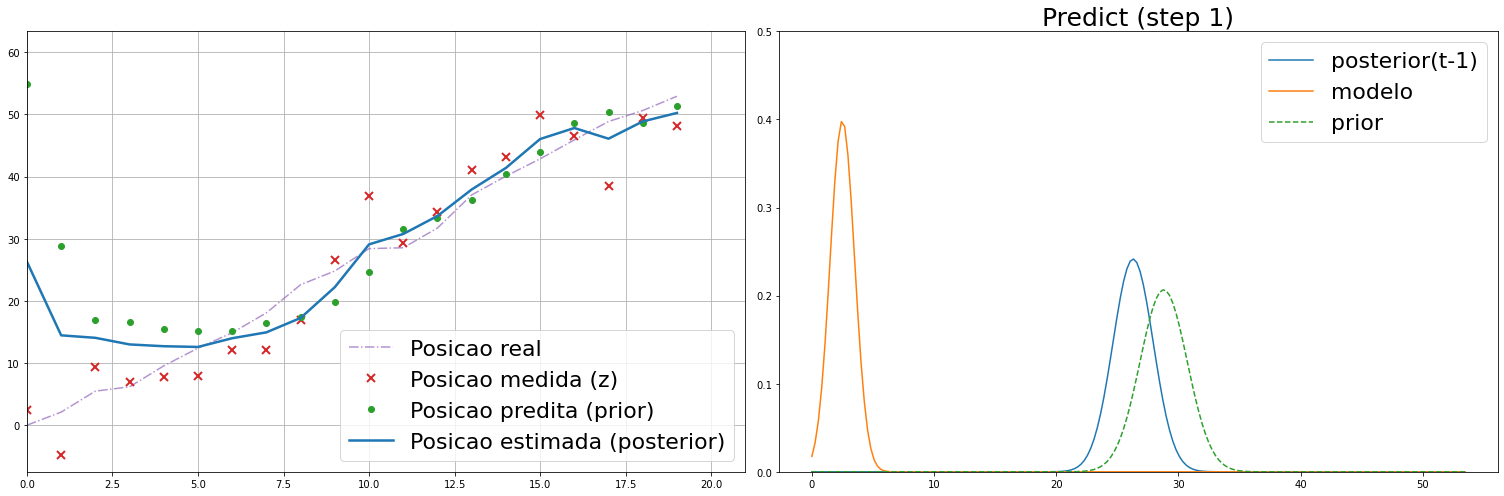

In [13]:
interact(plot_kalman_steps, step = IntSlider(1, 1, (int(tf/dt)-1)*4),
        pos_real = fixed(pos_real), modelo = fixed(modelo),
        predito = fixed(predito), estimado = fixed(estimado),
        zs = fixed(zs), R = fixed(R));

# Gaussianas Multivariadas

## **Função Gaussiana Multivariada**

- Embora o Filtro de Kalman univariado funcione bem, problemas práticos raramente possuem apenas uma variável.
- Agora estamos interessados em modelar problemas com diversas variáveis.



## Considerações:



- Filtro de Kalman multivariado possui diversas variáveis de estado e/ou diversas variáveis medidas.


- Variáveis podem não ser independentes. Ou seja, podem ter correlação entre si.


Vamos agora lidar com modelos multidimensionais. As variáveis de estado e medições podem ser representadas por meio de vetores:

$
\vec{x} = \begin{bmatrix}x_1\\x_2\\ \vdots \\x_n\end{bmatrix} \quad  $ $\vec{z} = \begin{bmatrix}z_1\\z_2\\ \vdots \\z_m\end{bmatrix}$

Onde:
- $\vec{x}$ representa os valores de variáveis de estado em um determinado instante
- $\vec{z}$ representa os valores das medições em determinado instante


### **Covariância**


- Agora que consideramos diversas variáveis que podem depender uma das outras, é esperado que a imprecisão de uma afete outra. 


- Na matriz de covariânica guardamos informação da relação de variância entre todas as variáveis.

$$
P = \begin{bmatrix}
  P_1^2 & P_{12} & \cdots & P_{1n} \\
  P_{21} & P_2^2 & \cdots & P_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  P_{n1} & P_{n2} & \cdots & P_n^2
 \end{bmatrix}
$$

$$
R = \begin{bmatrix}
  R_1^2 & R_{12} & \cdots & R_{1n} \\
  R_{21} & R_2^2 & \cdots & R_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  R_{n1} & R_{n2} & \cdots & R_n^2
 \end{bmatrix}
$$

- Cada elemento dessas matrizes simétricas $P$ e $R$ é uma covariância entre duas variáveis.

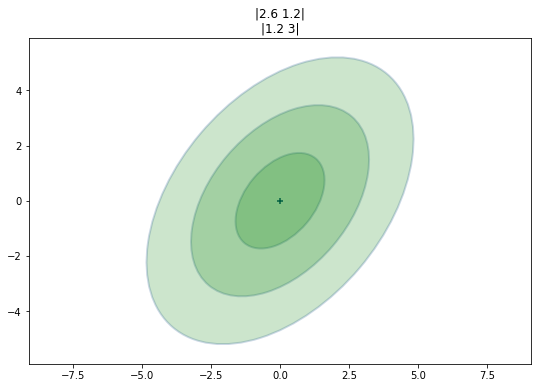

In [14]:
interact(interactive_covariance,
         v_a = FloatSlider(value = 2, min = .1, max = 10),
         v_b = FloatSlider(value = 2, min = .1, max = 10),
         v_ab = FloatSlider(value = 0, min = -5, max = 5));

<center><img src="./fig/gaussiancomp.png" style="width: 90%">
</center>

In [15]:
interactive_covariance_multiply = interactive(plot_interactive_covariance_multiply,
         x1 = FloatSlider(value = 2, min = .1, max = 10),
         x2 = FloatSlider(value = 2, min = .1, max = 10),
         x12 = FloatSlider(value = 0, min = 0, max = 5),
         z1 = FloatSlider(value = 2, min = .1, max = 10),
         z2 = FloatSlider(value = 2, min = .1, max = 10),
         z12 = FloatSlider(value = 0, min = 0, max = 5));

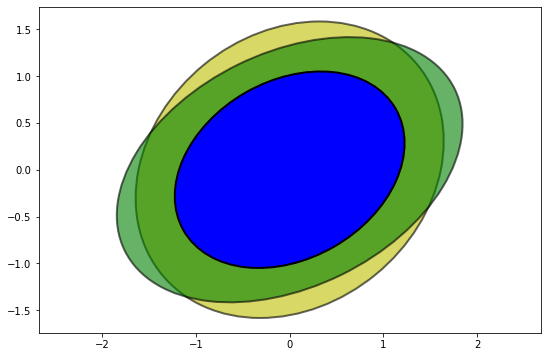

In [16]:
interactive_covariance_multiply

# Kalman Filter Multivariado

- **Gaussianas Unidimensionais** substituidas por **Gaussianas Multivariadas**.

- Médias substituídas por **vetor de médias**.
- Variâncias substituídas por **matrizes de covariâncias**.
- Necessidade de adaptar as equações para operações vetor-matriz, utilizando a **álgebra linear**.

## Kalman Filter Univariado VS Multivariado

<center><img src="./fig/pred_update.png" style="width: 60%"></center>

# Variáveis

<center><img src="./fig/variaveis.png" style="width: \linewidth"></center>



# Matriz de Transição (F)

- Recebe um estado e computa previsão para o estado seguinte.

- Forma matricial de equações de diferenças!


# Matriz de conversão de Medições (H)

- Projeta variáveis de estado no espaço das medições.


# Variáveis de Controle (b,U)

- u é a variável de controle.
- B é a função de controle.
- Ex. Aceleração.

# Etapas

Da mesma forma que o Kalman Filter Unidimensional, o caso multivariado se divide em três etapas: *inicialização, predict e update*. Vamos entender como cada um deles funciona.

# *Inicialização*

**Ideia:** Fornecer valor de estado inicial e matriz de covariância inicial.

# *Predict*

**Ideia:** usar o modelo fazer uma previsão sobre o estado do sistema no próximo intervalo de tempo e estimar o erro associado com essa previsão.

## Passo 1

Usar o modelo para computar o prior $$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}.$$



## Passo 2

Computar a matriz de covariância do prior $$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q. $$

<center><img src="./fig/pred_update.png" style="width: 45%"></center>

# Update

**Ideia:** incorporar informações de medidas ao prior, de modo a obter estimativa final para o estado do sistema no próximo intervalo de tempo.




## Passo 1

Obter uma medida $z$ e matriz de covariância $R$ associada a elas.


## Passo 2

Computar o resíduo entre o pior e a medida:

$$\mathbf y = \mathbf z - \mathbf{H\bar{x}}.$$


## Passo 3

Computar fator de escala (ganho de Kalman): 

$$\mathbf K = \mathbf{\bar{P}H}^\mathsf T(\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}$$


## Passo 4

Usar o fator de escala para obter a estimativa final(posterior). 

$$x  = \bar{\mathbf x} + \mathbf{Ky}$$

## Passo 5

Combinar a matriz de covariância do prior e das medidas para calcular a matriz de covariância associada ao posterior

$$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}.$$

<center><img src="./fig/pred_update.png" style="width: 50%"></center>

## Implementação do Kalman Filter Multivariado

In [17]:
def kalman_filter(x0, z, F, B, Q, u, H, R):
    x = x0
    P = B @ Q @ B.T # Cálculo da covariância inicial
    x_hat = [flatten(x0)] # Lista para guardar a trajetória do estado estimado
    
    for i in range(1, len(z)):
        # Predict
        x_, P_ = predict(x, P, Q, F, B, u) 
        
        # Update
        z_i = z[i] # Medição do tempo i
        x, P = update(x_, P_, z_i, H, R) 
        
        x_hat.append(flatten(x)) # Adiciona estimativa à trajetória
    
    return np.matrix(x_hat)

In [18]:
def predict(x, P, Q, F, B, u):
    x_ = F @ x + B @ u             # Média a priori
    P_ = F @ P @ F.T + B @ Q @ B.T # Covariância a priori
    return x_, P_

def update(x_, P_, z, H, R):
    y = z.T - H @ x_                     # Resíduo (ou inovação)
    S = H @ P_ @ H.T + R                 # Covariância da inovação
    K = P_ @ H.T @ inv(S)                # Ganho de Kalman
    x = x_ + K @ y                       # Média a posteriori
    P = (np.eye(len(P_)) - K @ H) @ P_   # Covariância a posteriori
    return x, P

# Exemplo: GPS de um veículo

Supomos o seguinte modelo de equações de diferença, que prevê a posição do carro dada sua posição atual e velocidade:
$$s_x(t+\Delta t) = s_x(t) + v_x \times \Delta t\\
s_y(t+\Delta t) = s_y(t) + v_y \times \Delta t$$
Onde:
- $s_x$ é a posição no eixo horizontal
- $s_y$ é a posição no eixo vertical
- $v_x$ é a velocidade referente a $s_x$
- $v_y$ é a velocidade referente a $s_y$
- $t$ é o tempo
- $\Delta t$ é a variação do tempo

Traduzindo para forma matricial:

$$\left\lbrack\begin{array}{c}
        s_x(t+1)\\
        v_x(t+1)\\
        s_y(t+1)\\
        v_y(t+1)
        \end{array}\right\rbrack
        = \left\lbrack\begin{array}{cccc}
        1 & \Delta t & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & \Delta t \\
        0 & 0 & 0 & 1
        \end{array}\right\rbrack
        \left\lbrack\begin{array}{c}
        s_x(t)\\
        v_x(t)\\
        s_y(t)\\
        v_y(t)
        \end{array}\right\rbrack
$$

Onde o vetor $[s_x, v_x, v_y, s_y]^T$ é o vetor de estados dos sitema. 

Obs: A velocidade foi adicionada ao vetor de estados. Desta forma, o Filtro de Kalman pode estimar não só a posição, mas também a velocidade do carro.

Esta será a nossa **matriz de transição**, ou seja, nosso modelo: 

$$ F = \left\lbrack\begin{array}{cccc}
        1 & \Delta t & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & \Delta t \\
        0 & 0 & 0 & 1
        \end{array}\right\rbrack$$

Sabemos que o GPS mede somente a posição do carro ($s_x$ e $s_y$).

Para projetar o estado do sistema $[s_x, v_x, s_y, v_y]^T$ no espaço das medições $[s_x, s_y]^T$, tomamos a matriz $H$ como: 

$$ H = \left\lbrack\begin{array}{cccc}
        1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        \end{array}\right\rbrack $$
        
$$
\left\lbrack\begin{array}{c}
   s_x\\
   s_y
\end{array}\right\rbrack 
= 
H
\cdot
\left\lbrack\begin{array}{c}
   s_x\\
   v_x\\
   s_y\\
   v_y
\end{array}\right\rbrack
$$

## Definindo modelo

In [19]:
# Delta t
dt = 1
# Função de transição
F = np.matrix([[1, dt, 0, 0], 
               [0, 1 , 0, 0],
               [0, 0 , 1, dt],
               [0, 0 , 0, 1]])

# Modelo de medições
H = np.matrix([[1, 0, 0, 0], 
               [0, 0, 1, 0]])

# B e u não são utilizados neste modelo, mas poderiam, 
# por exemplo, receber dados da aceleração do veículo

# Modelo de controle do input (matriz identidade)
B = np.matrix(np.identity(len(F)))
# Vetor de input (matriz de zeros)
u = np.matrix(np.zeros(len(F))).T

In [20]:
# Matriz de covariância do sensor.
R = np.matrix([[5**2, 0],
               [0, 5**2]])

# Matriz de covariância do modelo.
Q = np.diag([0, 0.005, 0, 0.005])

# Obs 1: Var(S_x) e Var(S_y) são 0 pois, em teoria, as variáveis 
# que causam o erro são da velocidade do veículo (devído a aceleração).

# Obs 2: Os valores da matriz Q foram ajustados manualmente

## Dados de medições do GPS

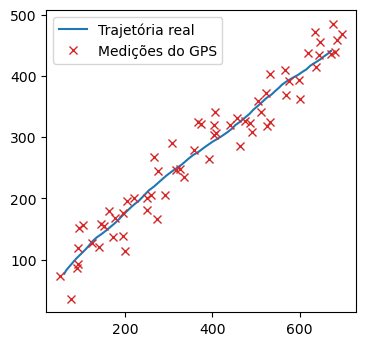

In [21]:
gps = pd.read_csv("reta.csv")
plt.figure(figsize = (4,4), dpi = 100)
plt.plot(gps["x"], gps["y"], label = "Trajetória real")
plt.plot(gps["x_obs"], gps["y_obs"], 'xC3', label = "Medições do GPS")
plt.legend();

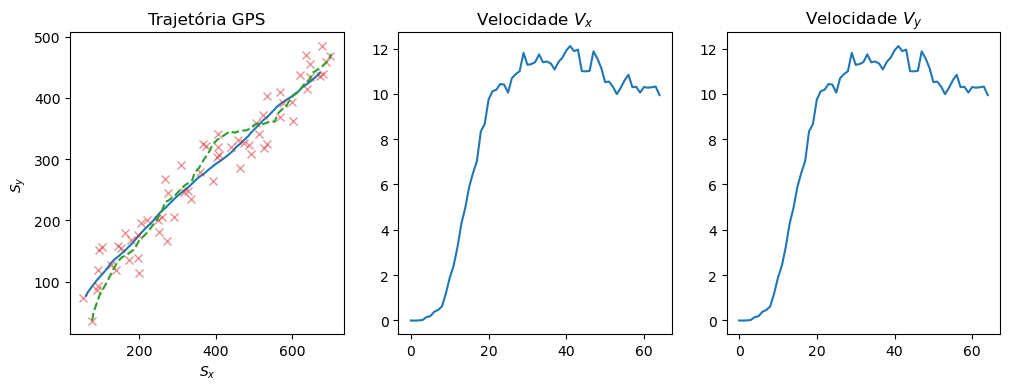

In [22]:
z = np.matrix(gps[["x_obs", "y_obs"]]) # Observações
x0 = np.matrix([[z[0,0], 0, z[0,1], 0]]).T # Estimativa inicial (igual a primeira medição)

x_kf = kalman_filter(x0, z, F, B, Q, u, H, R)
plot_kf_results(gps, x_kf)

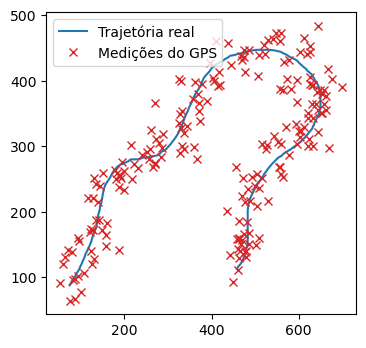

In [23]:
gps = pd.read_csv("curvas.csv")
plt.figure(figsize = (4,4), dpi = 100)
plt.plot(gps["x"], gps["y"], label = "Trajetória real")
plt.plot(gps["x_obs"], gps["y_obs"], 'xC3', label = "Medições do GPS")
plt.legend();

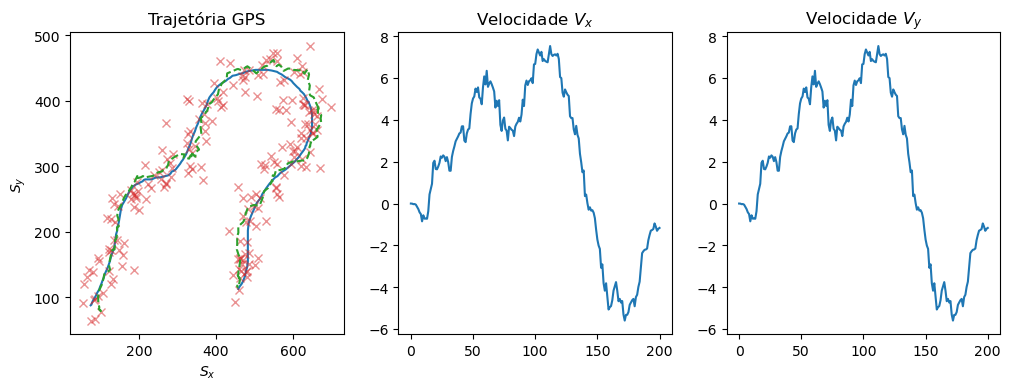

In [24]:
z = np.matrix(gps[["x_obs", "y_obs"]]) # Observações
x0 = np.matrix([[z[0,0], 0, z[0,1], 0]]).T # Estimativa inicial (igual a primeira medição)

x_kf = kalman_filter(x0, z, F, B, Q, u, H, R)
plot_kf_results(gps, x_kf)

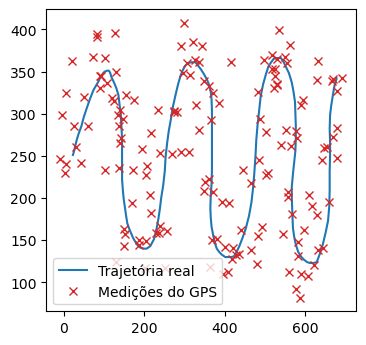

In [25]:
gps = pd.read_csv("manobra.csv")
plt.figure(figsize = (4,4), dpi = 100)
plt.plot(gps["x"], gps["y"], label = "Trajetória real")
plt.plot(gps["x_obs"], gps["y_obs"], 'xC3', label = "Medições do GPS")
plt.legend();

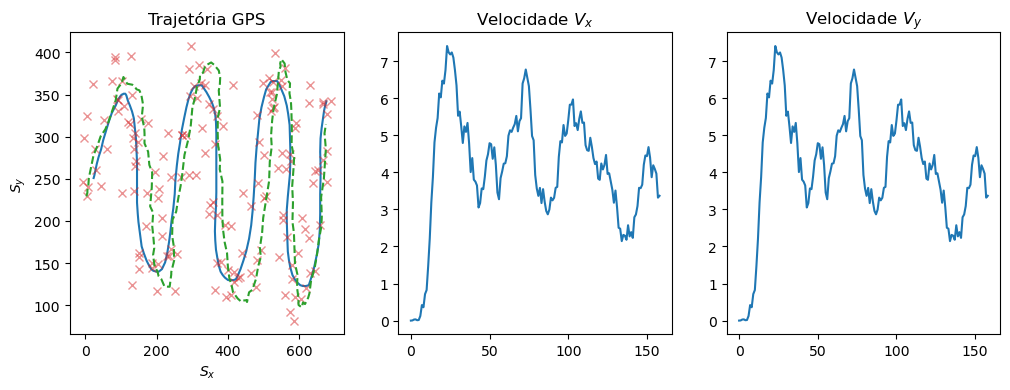

In [26]:
z = np.matrix(gps[["x_obs", "y_obs"]]) # Observações
x0 = np.matrix([[z[0,0], 0, z[0,1], 0]]).T # Estimativa inicial (igual a primeira medição)

x_kf = kalman_filter(x0, z, F, B, Q, u, H, R)
plot_kf_results(gps, x_kf)

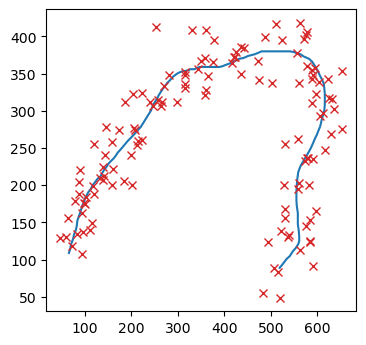

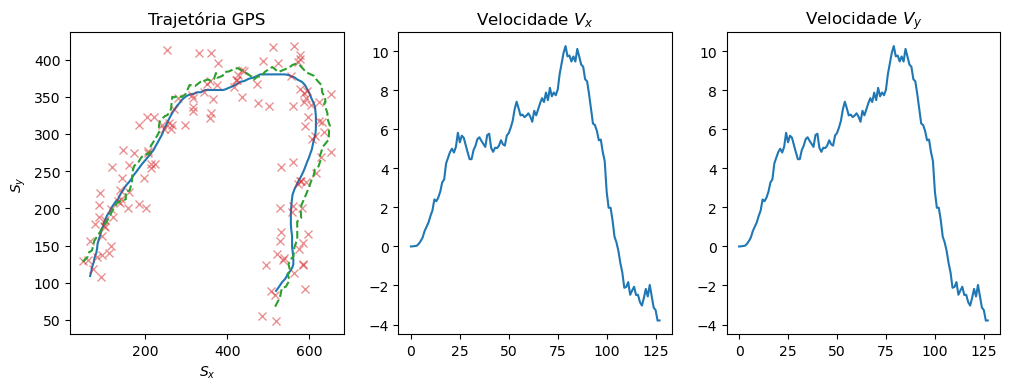

In [27]:
# Para carregar um novo arquivo:
# Acessar o site: https://drawdata.xyz/
# Desenhe uma trajetória e salve em um arquivo <nome do arquivo>.csv
# Substitua o nome do arquivo na variável "filename" e execute a célula (não esqueça de executar o resto do notebook antes)

filename = "trajetoria.csv"
df = pd.read_csv(filename)[["x", "y"]]

r = np.random.normal(df, 5**2)
df["x_obs"] = r[:,0]
df["y_obs"] = r[:,1]

plt.figure(figsize = (4,4), dpi = 100)
plt.plot(df["x"], df["y"])
plt.plot(df["x_obs"], df["y_obs"], 'xC3')
plt.show()

df.to_csv(filename, index = False)

# Executando filtro de kalman
gps = pd.read_csv(filename)

z = np.matrix(gps[["x_obs", "y_obs"]]) # Observações
x0 = np.matrix([[z[0,0], 0, z[0,1], 0]]).T # Estimativa inicial (igual a primeira medição)

x_kf = kalman_filter(x0, z, F, B, Q, u, H, R)
plot_kf_results(gps, x_kf)

In [28]:
# %%HTML
# <style>

# .container {
#     width: 85% !important;
# }

# .rendered_html {
#   font-size: 0.73em;
# }
# .rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
#      font-size: 100%;
# }

# # .CodeMirror {
# #     font-size: 1em;
# # #     width: 100vw;
# # }

# .prompt{
#     display: None;
# }

# # .output {
# #     align-items: center;
# # }

# div.output_subarea {
#     max-width: 100%;
# }

# </style>

%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 85% !important;
}

.rendered_html {
  font-size: 1.4vw;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

.CodeMirror {
    font-size: 0.8vw;
}

.prompt{
    display: None;
}

</style>